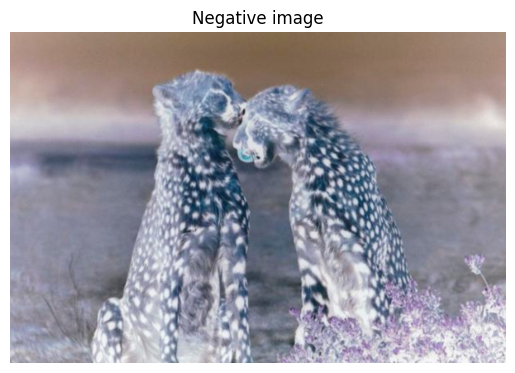

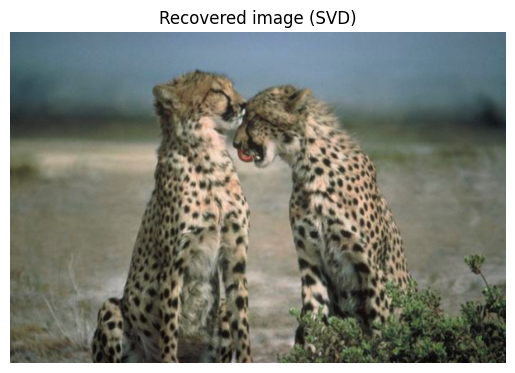

In [8]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

np.random.seed(42)

def transpose(matrix):
    return [list(row) for row in zip(*matrix)]

def matmul(A, B):
    result = []
    for i in range(len(A)):
        row = []
        for j in range(len(B[0])):
            row.append(sum(A[i][k] * B[k][j] for k in range(len(A[0]))))
        result.append(row)
    return result

def identity_matrix(n):
    return [[1 if i == j else 0 for j in range(n)] for i in range(n)]

def diagonal_inv(sigma, tol=1e-10):
    return [[1/sigma[i] if i == j and sigma[i] > tol else 0 for j in range(len(sigma))] for i in range(len(sigma))]

def norm(v):
    return sum(x**2 for x in v) ** 0.5

def dot(u, v):
    return sum(u[i]*v[i] for i in range(len(u)))

def subtract(u, v):
    return [u[i] - v[i] for i in range(len(u))]

def scalar_multiply(s, v):
    return [s * x for x in v]

def gram_schmidt(A):
    Q = []
    for a in A:
        u = a[:]
        for q in Q:
            proj = scalar_multiply(dot(u, q), q)
            u = subtract(u, proj)
        u_norm = norm(u)
        if u_norm > 1e-10:
            Q.append(scalar_multiply(1/u_norm, u))
    return Q

def eigen_decomposition_sym(A, num_iter=100):
    n = len(A)
    V = identity_matrix(n)
    for _ in range(num_iter):
        for p in range(n):
            for q in range(p+1, n):
                if abs(A[p][q]) < 1e-10:
                    continue
                theta = 0.5 * np.arctan2(2*A[p][q], A[q][q] - A[p][p])
                cos = np.cos(theta)
                sin = np.sin(theta)
                for i in range(n):
                    Api = A[i][p]
                    Aiq = A[i][q]
                    A[i][p] = cos * Api - sin * Aiq
                    A[i][q] = sin * Api + cos * Aiq
                for j in range(n):
                    Apj = A[p][j]
                    Aqj = A[q][j]
                    A[p][j] = cos * Apj - sin * Aqj
                    A[q][j] = sin * Apj + cos * Aqj
                for i in range(n):
                    Vip = V[i][p]
                    Viq = V[i][q]
                    V[i][p] = cos * Vip - sin * Viq
                    V[i][q] = sin * Vip + cos * Viq
    eigenvalues = [A[i][i] for i in range(n)]
    return eigenvalues, V

def svd_inverse(A):
    A_T = transpose(A)
    ATA = matmul(A_T, A)
    ATA_copy = [row[:] for row in ATA]
    eigvals, V = eigen_decomposition_sym(ATA_copy)

    eig_pairs = sorted(zip(eigvals, transpose(V)), key=lambda x: -x[0])
    sorted_vals, sorted_V_cols = zip(*eig_pairs)
    sigma = [val**0.5 if val > 1e-10 else 0 for val in sorted_vals]
    sigma_inv = diagonal_inv(sigma)

    V = transpose(list(sorted_V_cols))
    AV = matmul(A, V)

    U = []
    for i in range(len(sigma)):
        if sigma[i] > 1e-10:
            col = [AV[j][i] / sigma[i] for j in range(len(AV))]
        else:
            col = [0.0 for _ in range(len(AV))]
        U.append(col)
    U_T = U

    temp = matmul(V, sigma_inv)
    return matmul(temp, U_T)


def restore_image(negative_img, T_inv):
    img = negative_img.astype(np.float32)
    h, w, _ = img.shape
    ones = np.ones((h, w, 1), dtype=np.float32)
    img_homogeneous = np.concatenate((img, ones), axis=2)
    img_reshaped = img_homogeneous.reshape(-1, 4).T
    restored = np.matmul(T_inv, img_reshaped)
    restored = restored[:3, :].T.reshape(h, w, 3)
    restored = np.clip(restored, 0, 255).astype(np.uint8)
    return restored

def show_image(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ---------- Main Execution ----------

T = [
    [-1, 0, 0, 255],
    [0, -1, 0, 255],
    [0, 0, -1, 255],
    [0, 0, 0, 1]
]

T_inv = svd_inverse(T)
T_inv = np.array(T_inv)

input_path = 'negative.png'
negative_img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

if negative_img is None:
    print("Помилка: не вдалося завантажити зображення.")
else:
    if negative_img.shape[2] == 4:
        negative_img = negative_img[:, :, :3]

    show_image(negative_img, "Negative image")

    restored_img = restore_image(negative_img, T_inv)

    show_image(restored_img, "Recovered image (SVD)")
    output_path = 'restored_image_svd.png'
    cv2.imwrite(output_path, restored_img)
